In [1]:
# !pip install numpy
# !pip install pillow
# !pip install tensorflow
# !pip install keras
# !pip install opencv-python
# !pip install matplotlib
# !pip install seaborn

# # using dataset https://www.kaggle.com/datasets/stoicstatic/face-recognition-dataset

In [2]:
import os
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.applications.mobilenet_v2  import MobileNetV2
from keras.applications.mobilenet_v2  import preprocess_input


random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)


2025-09-12 06:24:30.678619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757633070.694899    5992 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757633070.700952    5992 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-12 06:24:30.718482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/binngo/miniconda3/envs/pyenv3.11/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDepend

Num GPUs Available:  1


In [3]:
FOLDER_FACE_PATH = './CelebDataProcessed'

def readImage(index):
    path = tf.strings.join([FOLDER_FACE_PATH, "/", index[0], "/", index[1]])

    # read file
    img = tf.io.read_file(path)

    # decode JPEG/PNG automatically
    img = tf.image.decode_image(img, channels=3, expand_animations=False)

    # convert dtype to float32 [0,255] → preprocess_input expects this
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, (256, 256))
    # # resize to MobileNet input size (224x224)
    # img = tf.image.resize(img, (224, 224))
    return img

  

def splitDataset(ratio=0.8):
    train = {}
    test = {}
    folders = os.listdir(FOLDER_FACE_PATH)
    folderTrainSize = int(len(folders) * ratio)
    random.shuffle(folders)

    trainFolders = folders[:folderTrainSize]
    testFolders = folders[folderTrainSize:]
    for folder in trainFolders:
        files = os.listdir(os.path.join(FOLDER_FACE_PATH, folder))
        train[folder] = files

    for folder in testFolders:
        files = os.listdir(os.path.join(FOLDER_FACE_PATH, folder))
        test[folder] = files
            
    return train, test
train, test = splitDataset(0.9)


622942 triplets created
57884 total triplets created
(('Orlando Bloom', '95.jpg'), ('Orlando Bloom', '553.jpg'), ('Dave Chappelle', '9.jpg'))


I0000 00:00:1757633074.248776    5992 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


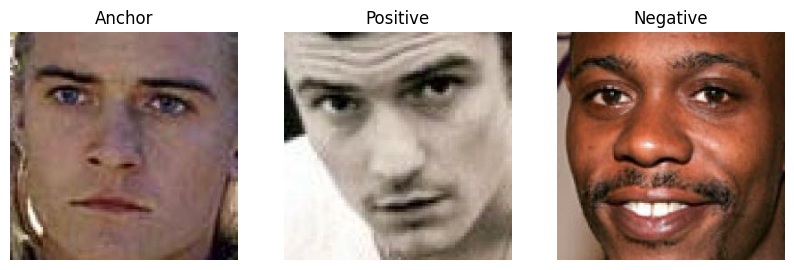

(('Lindsay Lohan', '202.jpg'), ('Lindsay Lohan', '306.jpg'), ('Nicole Kidman', '163.jpg'))


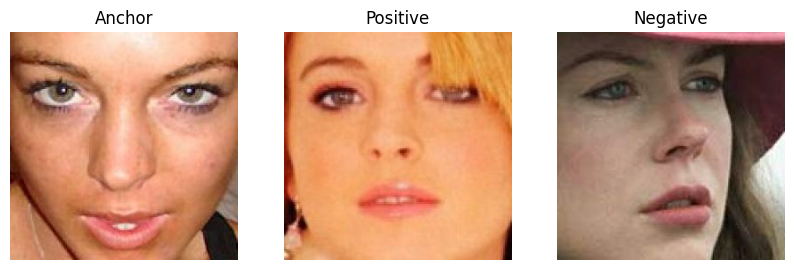

(('Orlando Bloom', '53.jpg'), ('Orlando Bloom', '544.jpg'), ('Sharon Stone', '17.jpg'))


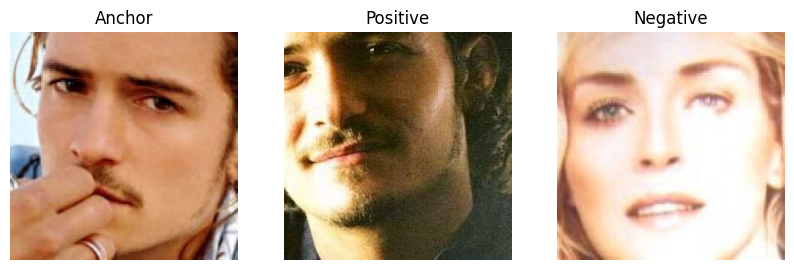

In [4]:

def createTriplet(train):
    # anchor and positive are from same class, negative is from different class
    triplets = []
    folders = list(train.keys())

    for folder in folders:
        files = train[folder]
        if len(files) < 2:
            continue
        anchorPositivePairs = []
        for i in range(len(files)):
            for j in range(i + 1, len(files)):
                anchorPositivePairs.append((files[i], files[j]))

        for anchor, positive in anchorPositivePairs:
            negativeFolder = folder
            while negativeFolder == folder:
                negativeFolder = random.choice(folders)
            negativeFiles = train[negativeFolder]
            negative = random.choice(negativeFiles)
            triplets.append(((folder, anchor), (folder, positive), (negativeFolder, negative)))
            
    random.shuffle(triplets)
    return triplets

tripletsTrain = createTriplet(train)
tripletsTest = createTriplet(test)
print (len(tripletsTrain), 'triplets created')
print (len(tripletsTest), 'total triplets created')

# Show image triplet
for i in range(3):
    print(tripletsTrain[i])
    anchor = readImage(tripletsTrain[i][0])
    positive = readImage(tripletsTrain[i][1])
    negative = readImage(tripletsTrain[i][2])

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(anchor)
    plt.title('Anchor')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(positive)
    plt.title('Positive')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(negative)
    plt.title('Negative')
    plt.axis('off')

    plt.show()




In [5]:

def batchGenerator(triplets, batchSize=32):
     while True:
        anchorBatch, positiveBatch, negativeBatch = [], [], []

        for _ in range(batchSize):
            triplet = random.choice(triplets)
            anchor = readImage(triplet[0])
            positive = readImage(triplet[1])
            negative = readImage(triplet[2])

            anchorBatch.append(anchor)
            positiveBatch.append(positive)
            negativeBatch.append(negative)

        # stack tensors into batch
        anchorBatch = tf.stack(anchorBatch, axis=0)
        positiveBatch = tf.stack(positiveBatch, axis=0)
        negativeBatch = tf.stack(negativeBatch, axis=0)

        # dummy labels (not used in triplet loss, but required by keras)
        labels = tf.zeros((batchSize, 1), dtype=tf.float32)

        yield (anchorBatch, positiveBatch, negativeBatch), labels





In [6]:
def getEmbeddingModel(inputShape):
    baseModel = MobileNetV2(input_shape=inputShape, include_top=False, weights='imagenet', pooling='avg')
    for layer in baseModel.layers[:-30]:
        layer.trainable = False

    for layer in baseModel.layers[-30:]:
        layer.trainable = True

    model = tf.keras.Sequential([
        baseModel,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name='Embedding')
    return model

In [7]:
#  Create siamese network model with triplet loss

# Distance layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
class DistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def getSiameseModel(inputShape=(128, 128, 3)):
    embeddingModel = getEmbeddingModel(inputShape)

    anchorInput = tf.keras.layers.Input(name='anchor', shape=inputShape)
    positiveInput = tf.keras.layers.Input(name='positive', shape=inputShape)
    negativeInput = tf.keras.layers.Input(name='negative', shape=inputShape)

    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)

    # Distance layer
    distances = DistanceLayer()(anchorEmbedding, positiveEmbedding, negativeEmbedding)

    model = tf.keras.Model(inputs=[anchorInput, positiveInput, negativeInput], outputs=distances, name='SiameseNetwork')
    return model

SiameseModel  = getSiameseModel((256, 256, 3))
SiameseModel.summary()

/tmp/ipykernel_5992/3306704198.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(input_shape=inputShape, include_top=False, weights='imagenet', pooling='avg')


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 256)       │  3,047,232 │ anchor[0][0],     │
│ (Sequential)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer      │ [(None), (None)]  │          0 │ Embedding[0][0],  │
│ (DistanceLayer)     │                   │            │ Embedding[1][0],  │
│                     │                   │            │ Embedding[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,047,232 (11.62 MB)

 Trainable params: 2,314,304 (8.83 MB)

 Non-trainable params: 732,928 (2.80 MB)

In [8]:
# Custom training step with triplet loss
class SiameseModelClass(tf.keras.Model):
    def __init__(self, siameseModel, margin=0.5):
        super(SiameseModelClass, self).__init__()
        self.siameseModel = siameseModel
        self.margin = margin
        self.lossTracker = tf.keras.metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siameseModel(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            ap_distance, an_distance = self.siameseModel(data[0], training=True)
            loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, self.siameseModel.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siameseModel.trainable_weights))
        self.lossTracker.update_state(loss)
        return {'loss': self.lossTracker.result()}

    def test_step(self, data):
        ap_distance, an_distance = self.siameseModel(data[0], training=False)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        loss = tf.reduce_mean(loss)
        self.lossTracker.update_state(loss)
        return {'loss': self.lossTracker.result()}

    @property
    def metrics(self):
        return [self.lossTracker]
    




In [9]:
siameseModel = SiameseModelClass(SiameseModel)
siameseModel.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

# early stopping callback
cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              mode='min', 
                              min_lr=0.00001)

cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/siameseModel_celeb.keras',
    monitor= 'val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
# data_set = batchGenerator(tripletsTest, batchSize=64)

# train_ds = tf.data.Dataset.from_generator(
#     lambda: batchGenerator(tripletsTrain, batchSize=64),
#     output_signature=(
#         (tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#     )
# ).prefetch(tf.data.AUTOTUNE)

# valid_ds = tf.data.Dataset.from_generator(
#     lambda: batchGenerator(tripletsTest, batchSize=64),
#     output_signature=(
#         (tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#     )
# ).prefetch(tf.data.AUTOTUNE)

def triplet_generator(triplets):
    for triplet in triplets:
        a = readImage(triplet[0])
        p = readImage(triplet[1])
        n = readImage(triplet[2])
        yield (a, p, n), 0  # dummy label for triplet loss

# Define output signature
output_signature = (    
    (
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
    ),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

# Training dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: triplet_generator(tripletsTrain),
    output_signature=output_signature
).shuffle(1000) \
 .batch(64) \
 .prefetch(tf.data.AUTOTUNE)

# Validation dataset
valid_ds = tf.data.Dataset.from_generator(
    lambda: triplet_generator(tripletsTest),
    output_signature=output_signature
).batch(64) \
 .prefetch(tf.data.AUTOTUNE)

# def map_fn(triplets):
#     a = readImage(triplets[0])
#     p = readImage(triplets[1])
#     n = readImage(triplets[2])
#     return (a, p, n), tf.zeros((1,))

# train_ds = tf.data.Dataset.from_tensor_slices(tripletsTrain) \
#     .shuffle(buffer_size=1000) \
#     .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
#     .batch(64) \
#     .prefetch(tf.data.AUTOTUNE)
# valid_ds = tf.data.Dataset.from_tensor_slices(tripletsTest) \
#     .shuffle(buffer_size=1000) \
#     .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
#     .batch(64) \
#     .prefetch(tf.data.AUTOTUNE)


In [ ]:

history = siameseModel.fit(train_ds,
          steps_per_epoch=100,
          validation_data=valid_ds,
          callbacks=[cb_early_stopping, cb_model_checkpoint,reduce_lr],
          validation_steps=100,
          epochs=128)


Epoch 1/128


2025-09-12 06:25:00.302112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 863 of 1000
2025-09-12 06:25:02.311387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1757633104.345222    6377 service.cc:148] XLA service 0x7a360c00c200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757633104.345269    6377 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-09-12 06:25:05.130404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757633109.058650    6377 cuda_dnn.cc:529] Loaded cuDNN version 90101
I0000 00:00:1757633130.314709    6377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proc

 17/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - loss: 0.4587

In [ ]:
# load best model 
loaded_model = tf.keras.models.load_model("encoder_celeb.weights.h5")
loaded_model.summary() 
def extractEncoder(model):
    encoder = getEmbeddingModel((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extractEncoder(siameseModel)
encoder.save_weights("encoder_celeb.weights.h5")
encoder.summary()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'enocder_cleb.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    # Euclidean distance between the encodings
    distance = np.sqrt(np.sum(np.square(tensor1-tensor2), axis=-1))
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [ ]:
pos_list = np.array([])
neg_list = np.array([])

for data in batchGenerator(tripletsTest, batchSize=256):
    print(data)
    a, p, n = data[0]
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

((<tf.Tensor: shape=(256, 256, 256, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.00784314],
         [0.        , 0.        , 0.        ],
         [0.00784314, 0.        , 0.00392157],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.      

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "mobilenetv2_1.00_128" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(32, 256, 256, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 256, 256, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # Accuracy, Precision, Recall, F1-Score
    print("\nClassification Report:\n")
    print(classification_report(true, pred, target_names=categories))
ModelMetrics(pos_list, neg_list)

In [ ]:
# test for 2 images
face_1 = readImage(('bin', '4.jpg'))
face_2 = readImage(('bin', '3.jpg'))


face_1 = cv2.resize(face_1, (128, 128))
face_2 = cv2.resize(face_2, (128, 128))

# show images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(face_1)
plt.title('Face 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(face_2)
plt.title('Face 2')
plt.axis('off')
plt.show()

face_1 = preprocess_input(face_1)
face_2 = preprocess_input(face_2)

#
face_1 = tf.convert_to_tensor(np.array([face_1], dtype="float32"))
face_2 = tf.convert_to_tensor(np.array([face_2], dtype="float32"))

prediction = classify_images(face_1, face_2, threshold=1.0)
print('Same person' if prediction[0]==0 else 'Different person')